Import dependecies

In [1]:
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import cycle
import keras
import pickle

import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Input
from tensorflow.keras.applications import vgg16
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,roc_curve, auc

In [2]:
import warnings
warnings.filterwarnings("ignore")

Set GPU Growth

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
physical_devices = tf.config.list_physical_devices('GPU')
for device in physical_devices:
    tf.config.experimental.set_memory_growth(device, True)

Data Preprocessing

In [4]:
def load_data(ImageDir, augmentation=False):
    images, labels = [], []
    
    # Create an ImageDataGenerator instance with augmentation configurations
    if augmentation:
        datagen = ImageDataGenerator(
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )
    
    # iterate through each celebrity
    for celebs in os.listdir(ImageDir):
        # iterate through each file in features
        for file in os.listdir(os.path.join(ImageDir, celebs)):
            img = cv2.imread(os.path.join(ImageDir, celebs, file))
            
            if augmentation:
                x = img.reshape((1,) + img.shape)
                i = 0
                for batch in datagen.flow(x, batch_size=1):
                    augmented_img = batch[0].astype(np.uint8)
                    images.append(augmented_img)
                    labels.append(celebs)
                    i += 1
                    if i >= 5:  # Generate 5 augmented images per original image
                        break
            else:
                images.append(img)
                labels.append(celebs)
    
    return images, labels

In [5]:
images,labels = load_data('../Facial dataset/Preprocessed dataset',augmentation=True)
le = LabelEncoder()
numlabels = le.fit_transform(labels)

In [6]:
def make_triplets(images,labels):
    A,P,N = [],[],[]
    numClasses = len(np.unique(labels))
    # index of labels for each class
    idx = [np.where(labels == i)[0] for i in np.arange(0, numClasses)]
    for i in np.arange(len(images)):
        # store current images
        A.append(images[i])
        label = labels[i]
        # positive images (same class with anchor)
        P_index = np.random.choice(idx[label])
        P.append(images[P_index])
        # negative images (different class with anchor)
        N_index = np.random.choice(np.where(labels != label)[0])
        N.append(images[N_index])
        
    A = np.array(A)
    P = np.array(P)
    N = np.array(N)
    
    return A,P,N

Split data and create triplets

In [7]:
X_train,X_temp,y_train,y_temp = train_test_split(images,numlabels,test_size=0.3,random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [8]:
train_anchor,train_positive,train_negative = make_triplets(X_train,y_train)
val_anchor,val_positive,val_negative = make_triplets(X_val,y_val)
test_anchor,test_positive,test_negative = make_triplets(X_test,y_test)

In [9]:
def display_triplets(A,P,N,seed=0):
    # randomize seed if not specified
    if seed == 0:
        seed = np.random.randint(0,len(A))
    else:
        seed = seed
    plt.subplot(1,3,1),plt.imshow(cv2.cvtColor(A[seed], cv2.COLOR_BGR2RGB)),plt.title('Anchor')
    plt.subplot(1,3,2),plt.imshow(cv2.cvtColor(P[seed], cv2.COLOR_BGR2RGB)),plt.title("Positive")
    plt.subplot(1,3,3),plt.imshow(cv2.cvtColor(N[seed], cv2.COLOR_BGR2RGB)),plt.title('Negative')
    plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
    plt.show()

Training triplets


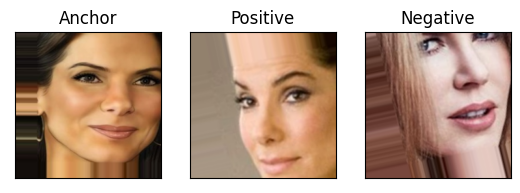

Validation triplets


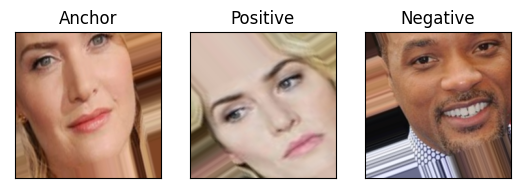

Testing triplets


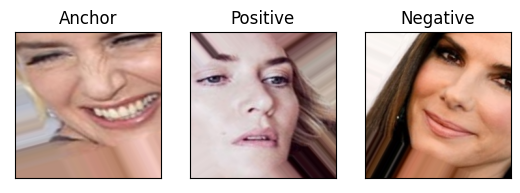

In [10]:
print("Training triplets")
display_triplets(train_anchor,train_positive,train_negative)
print("Validation triplets")
display_triplets(val_anchor,val_positive,val_negative)
print("Testing triplets")
display_triplets(test_anchor,test_positive,test_negative)

Model Architecture

In [11]:
def create_embedding_model(input_shape):
    # construct the input layer and pass the inputs through a
    # pre-processing layer
    inputs = keras.Input(input_shape)
    x = vgg16.preprocess_input(inputs)
    
    # fetch the pre-trained resnet 50 model and freeze the weights
    baseCnn = vgg16.VGG16(weights="imagenet", include_top=False)
    baseCnn.trainable=False
    
    # pass the pre-processed inputs through the base cnn and get the
    # extracted features from the inputs
    extractedFeatures = baseCnn(x)
    # pass the extracted features through a number of trainable layers
    x = layers.GlobalAveragePooling2D()(extractedFeatures)
    x = layers.Dense(units=1024, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dense(units=256, activation="relu")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units=128)(x)
    # build the embedding model and return it
    embedding = keras.Model(inputs, outputs, name="embedding")
    return embedding

In [12]:
feature_extractor = create_embedding_model((224,224,3))
feature_extractor.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (  (None, 224, 224, 3)       0         
 SlicingOpLambda)                                                
                                                                 
 tf.nn.bias_add (TFOpLambda  (None, 224, 224, 3)       0         
 )                                                               
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d (  (None, 512)               0         
 GlobalAveragePooling2D)                                         
                                                         

In [13]:
def create_siamese_network(input_shape,embedding_model):
    # Define tensors for the triplet of input images
    anchor_input = Input(input_shape,name='anchor_input')
    positive_input = Input(input_shape,name='positive_input')
    negative_input = Input(input_shape,name='negative_input')
    
    # Generate emebedding outputs
    encoded_anchor = embedding_model(anchor_input)
    encoded_positive = embedding_model(positive_input)
    encoded_negative = embedding_model(negative_input)
    
    inputs = [anchor_input,positive_input,negative_input]
    outputs = [encoded_anchor,encoded_positive,encoded_negative]
    
    model = keras.Model(inputs=inputs,outputs=outputs,name='embedding')    
    return model

Create and Train Siamese model

In [14]:
class SiameseModel(keras.Model):
    def __init__(self, siameseNetwork, margin, lossTracker):
        super().__init__()
        self.siameseNetwork = siameseNetwork
        self.margin = margin
        self.lossTracker = lossTracker
    def _compute_distance(self, inputs):
        (anchor, positive, negative) = inputs
        # embed the images using the siamese network
        embeddings = self.siameseNetwork((anchor, positive, negative))
        anchorEmbedding = embeddings[0]
        positiveEmbedding = embeddings[1]
        negativeEmbedding = embeddings[2]
        # calculate the anchor to positive and negative distance
        apDistance = tf.reduce_sum(
            tf.square(anchorEmbedding - positiveEmbedding), axis=-1
        )
        anDistance = tf.reduce_sum(
            tf.square(anchorEmbedding - negativeEmbedding), axis=-1
        )
        
        # return the distances
        return (apDistance, anDistance)
    def _compute_loss(self, apDistance, anDistance):
        loss = apDistance - anDistance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss
    
    def call(self, inputs):
        # compute the distance between the anchor and positive,
        # negative images
        (apDistance, anDistance) = self._compute_distance(inputs)

        # Get the embeddings from the Siamese network
        (anchorEmbedding, positiveEmbedding, negativeEmbedding) = self.siameseNetwork(inputs)

        # Return the distances and embeddings
        return (apDistance, anDistance, anchorEmbedding, positiveEmbedding, negativeEmbedding)

    def train_step(self, inputs):
        with tf.GradientTape() as tape:
            # compute the distance between the anchor and positive,
            # negative images
            (apDistance, anDistance) = self._compute_distance(inputs)
            # calculate the loss of the siamese network
            loss = self._compute_loss(apDistance, anDistance)
        # compute the gradients and optimize the model
        gradients = tape.gradient(
            loss,
            self.siameseNetwork.trainable_variables)
        self.optimizer.apply_gradients(
            zip(gradients, self.siameseNetwork.trainable_variables)
        )
        # update the metrics and return the loss
        self.lossTracker.update_state(loss)
        return {"loss": self.lossTracker.result()}
    def test_step(self, inputs):
        # compute the distance between the anchor and positive,
        # negative images
        (apDistance, anDistance) = self._compute_distance(inputs)
        # calculate the loss of the siamese network
        loss = self._compute_loss(apDistance, anDistance)
        
        # update the metrics and return the loss
        self.lossTracker.update_state(loss)
        return {"loss": self.lossTracker.result()}
    @property
    def metrics(self):
        return [self.lossTracker]

Final data preparation

In [15]:
# Create a generator function that yields the data in batches.
def data_generator(anchor, positive, negative, batch_size=32):
    while True:
        batch_indices = np.random.choice(len(anchor), batch_size, replace=False)
        anchor_batch = [anchor[i] for i in batch_indices]
        positive_batch = [positive[i] for i in batch_indices]
        negative_batch = [negative[i] for i in batch_indices]

        yield (np.array(anchor_batch), np.array(positive_batch), np.array(negative_batch))

In [16]:
# Create tf.data.Dataset using the generator function.
batch_size = 16
train_dataset = tf.data.Dataset.from_generator(
    data_generator,
    args=(train_anchor, train_positive, train_negative, batch_size),
    output_signature=(
        tf.TensorSpec(shape=(batch_size, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(batch_size, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(batch_size, 224, 224, 3), dtype=tf.float32),
    )
)
val_dataset = tf.data.Dataset.from_generator(
    data_generator,
    args=(val_anchor, val_positive, val_negative, batch_size),
    output_signature=(
        tf.TensorSpec(shape=(batch_size, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(batch_size, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(batch_size, 224, 224, 3), dtype=tf.float32),
    )
)

In [17]:
# Create an EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',   # Monitor validation loss
    patience=5,            # Number of epochs with no improvement to wait
    restore_best_weights=True  # Restore model weights to the best iteration
)

In [18]:
input_shape = (224,224,3)
embedding_model = create_embedding_model(input_shape)
siameseNetwork = create_siamese_network(input_shape,embedding_model)
siameseModel = SiameseModel(
    siameseNetwork=siameseNetwork,
    margin=0.5,
    lossTracker=keras.metrics.Mean(name="loss")
)

In [19]:
siameseModel.compile(optimizer=keras.optimizers.Adam(0.0001),weighted_metrics=[])
# Train the siamese model
history = siameseModel.fit(train_dataset,epochs=10,validation_data=val_dataset,validation_steps=10,steps_per_epoch=50,callbacks=[early_stopping])
# Save the model
#siameseModel.save("embedding_model",save_format='tf')

Epoch 1/10
50/50 [==============================] - 564s 9s/step - loss: 11.6574 - val_loss: 7.5087
Epoch 2/10
50/50 [==============================] - 359s 7s/step - loss: 4.9036 - val_loss: 4.1229
Epoch 3/10
50/50 [==============================] - 363s 7s/step - loss: 2.5705 - val_loss: 4.0012
Epoch 4/10
50/50 [==============================] - 362s 7s/step - loss: 2.3846 - val_loss: 3.1819
Epoch 5/10
50/50 [==============================] - 362s 7s/step - loss: 1.6938 - val_loss: 2.4545
Epoch 6/10
50/50 [==============================] - 362s 7s/step - loss: 1.4355 - val_loss: 2.6313
Epoch 7/10
50/50 [==============================] - 362s 7s/step - loss: 1.0411 - val_loss: 1.4873
Epoch 8/10
50/50 [==============================] - 367s 7s/step - loss: 0.8225 - val_loss: 1.9587
Epoch 9/10
50/50 [==============================] - 362s 7s/step - loss: 0.6725 - val_loss: 1.5528
Epoch 10/10
50/50 [==============================] - 362s 7s/step - loss: 0.6114 - val_loss: 0.8685


Training result

In [20]:
def loss_plotting(H):
    # construct a plot that plots and saves the training history
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(H.history["loss"], label="train_loss")
    plt.plot(H.history["val_loss"], label="val_loss")
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    plt.savefig('VGG 16 Loss graph.png')
    plt.show()

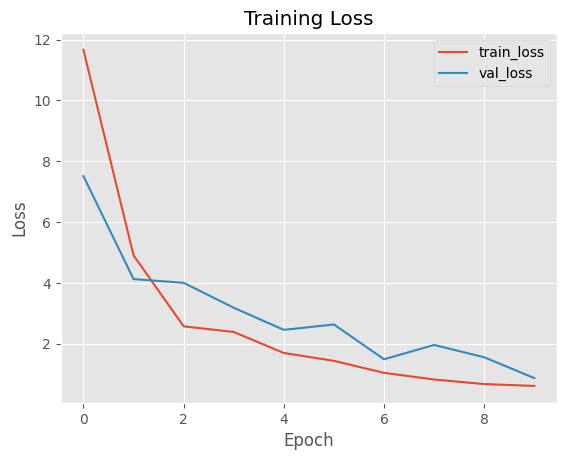

In [21]:
# plot the loss training history
loss_plotting(history)

Feature Visualization

In [ ]:
train_pos_dist,train_neg_dist,trained_anchor,trained_positive,trained_negative = siameseModel.predict(
                                                                (train_anchor,train_positive,train_negative)
                                                                )

In [ ]:
pos_dist,neg_dist,tested_anchor,tested_positive,tested_negative = siameseModel.predict(
                                                                        (test_anchor,test_positive,test_negative)
                                                                      )

In [ ]:
range=100
X_axis = np.arange(range)
plt.figure(figsize=(20,10))
plt.bar(X_axis - 0.2, pos_dist[:range], 0.4, label = 'Positive')
plt.bar(X_axis + 0.2, neg_dist[:range], 0.4, label = 'Negative')
plt.xticks(np.arange(min(X_axis), max(X_axis)+1, 5.0))
plt.xlabel("Number of Images")
plt.ylabel("Distance")
plt.title("Positive Distance vs Negative Distance")
plt.legend()
plt.show()

In [ ]:
def display_features(A,P,N):
    fig = plt.figure(figsize=(12,5))
    ax1 = fig.add_subplot(111)
    ax1.scatter(y=A[0][:50],x=np.arange(50),label='anchor')
    ax1.scatter(y=P[0][:50],x=np.arange(50),label='positive')
    ax1.scatter(y=N[0][:50],x=np.arange(50),label='negative')
    plt.legend(loc='upper left')
    plt.show()

In [ ]:
display_features(tested_anchor,tested_positive,tested_negative)

Classification model - KNN

In [ ]:
KNN_train = np.concatenate((trained_anchor,trained_positive))
KNN_test = np.concatenate((tested_anchor,tested_positive))
KNN_yTrain = np.concatenate((y_train,y_train.copy()))
KNN_yTest = np.concatenate((y_test,y_test.copy()))

In [ ]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(KNN_train, KNN_yTrain)
y_pred = knn.predict(KNN_test)
print("Overall Accuracy:", accuracy_score(KNN_yTest, y_pred)*100,"%")

In [ ]:
# save the model to disk
filename = 'classification_model.sav'
pickle.dump(knn, open(filename, 'wb'))

Evaluation

In [ ]:
labels_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
sorted_labels = [label for label, _ in sorted(labels_mapping.items(), key=lambda x: x[1])]

fig, ax = plt.subplots(figsize=(10, 8))
mat = confusion_matrix(KNN_yTest,y_pred)
sns.heatmap(mat.T,square=True,annot=True,fmt='d',cbar=False)

# Set y-axis tick labels using the list of label names
ax.set_yticklabels(sorted_labels, rotation=0)
ax.yaxis.tick_right()

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
print(classification_report(KNN_yTest, y_pred))

In [ ]:
# Binarize the labels for ROC analysis
y_train_bin = label_binarize(KNN_yTrain, classes=np.unique(KNN_yTrain))
y_test_bin = label_binarize(KNN_yTest, classes=np.unique(KNN_yTrain))
n_classes = len(np.unique(KNN_yTrain))

# Compute ROC curve and ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in np.arange(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], knn.predict_proba(KNN_test)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class 
plt.figure(figsize=(10, 8))
colors = cycle([
    'blue', 'orange', 'green', 'red', 'purple', 
    'brown', 'pink', 'gray', 'olive', 'cyan', 
    'magenta', 'yellow', 'teal', 'lime', 'indigo', 
    'maroon', 'navy'
])
for i, color in zip(np.arange(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (AUC = {1:.2f})'.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multi-Class ROC Curve')
plt.legend(loc='lower right')
plt.show()